In [5]:
!pip install tbats

     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 1.4 MB 7.0 MB/s 
     |████████████████████████████████| 9.8 MB 31.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
path = '/content/drive/MyDrive/Colab Datasets/Daily Bike Sharing.csv'

In [4]:
data = pd.read_csv(path,index_col = "dteday", parse_dates = True)
data.head(5)

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
#Select variables
dataset = data.loc[:, ["cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head(5)    

,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [7]:
#Rename the dependent variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset.head(5)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [8]:
#Modify the index to daily frequency
dataset = dataset.asfreq("D")
dataset.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq='D')

Training and Test set split

In [9]:
#Training and test set 
#We will use the last month of 2012 --> December 2012
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]

In [10]:
#Importing library
from tbats import TBATS

In [13]:
#TBATS model
model = TBATS(use_trend = True, seasonal_periods = [7, 365.5])
model = model.fit(training_set['y'])

#seasonal_periods: include the weekly pattern and yearly pattern

In [15]:
#We perform predictions
predictions_tbats = model.forecast(steps = len(test_set))
predictions_tbats

array([4828.2722494 , 4482.06441435, 4362.51396094, 4305.123489  ,
       4260.33832753, 4217.32149257, 4174.36372802, 4131.34239966,
       4088.29403304, 4045.23847949, 4002.18150899, 3959.12434942,
       3916.0671869 , 3873.01003246, 3829.95288124, 3786.89573084,
       3743.8385806 , 3700.78143038, 3657.72428017, 3614.66712995,
       3571.60997973, 3528.55282951, 3485.49567929, 3442.43852907,
       3399.38137885, 3356.32422863, 3313.26707841, 3270.20992819,
       3227.15277797, 3184.09562775, 3141.03847753])

We have an array of numbers, so we need to give it the structure of a dataframe

In [16]:
#We perform predictions and use Pandas to give structure to the data
predictions_tbats = pd.Series(model.forecast(steps = len(test_set)))
predictions_tbats.head()

0    4828.272249
1    4482.064414
2    4362.513961
3    4305.123489
4    4260.338328
dtype: float64

The outcome is still incomplete. We do not have a name of the frame and we do not have an index

In [17]:
#We perform predictions, use Pandas to give structure to the data, rename the prediction and set the index
predictions_tbats = pd.Series(model.forecast(steps = len(test_set))).rename("TBATS")
predictions_tbats.index = test_set.index
predictions_tbats.head()

dteday
2012-12-01    4828.272249
2012-12-02    4482.064414
2012-12-03    4362.513961
2012-12-04    4305.123489
2012-12-05    4260.338328
Freq: D, Name: TBATS, dtype: float64

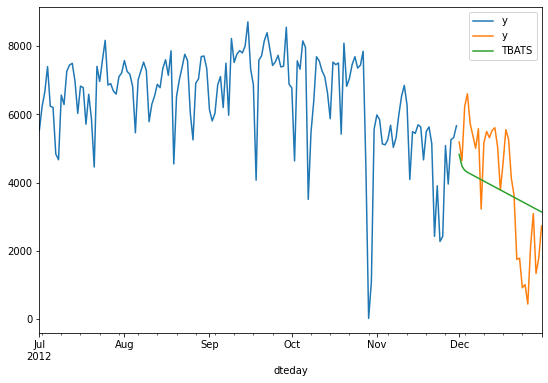

In [18]:
#Visualisation of our model
training_set['y']['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True)
predictions_tbats.plot(legend = True)

Model assessment

In [19]:
#We use again MAE and RMSE
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_tbats),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_tbats)), 0))

1299.0
1494.0


In [20]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_tbats)

68.06406403722941

Export the predictions

In [21]:
%cd /content/drive/MyDrive/Colab Datasets

/content/drive/MyDrive/Colab Datasets


In [22]:
predictions_tbats.to_csv('predictions_tbats.csv', index = True)